# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk

In [104]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [105]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) FROM DATASET --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv = df.groupby("conversation_id").count()
df_conv = df_conv.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv[df_conv["dialog_turn"] == 1]
print("Number of monologues in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv[df_conv["dialog_turn"] > 2]
print("Number of dialogues longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of monologues in subreddit:  29
Number of dialogues longer than 2 turns in subreddit:  487


In [106]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Measuring the level of engagement

### Does the speaker respond back when the listener gives a response?

In [107]:
def extract_responses(conversation):
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses)
    num_listener_responses = len(listener_responses)
    
    return speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

In [109]:
def calculate_engagement(speaker_responses, num_speaker_responses, num_listener_responses):
    speaker_listener_difference = num_speaker_responses - num_listener_responses
    
    engagement = ""
    if len(conversation) == 2:
        engagement = "low engagement"
    elif len(conversation) == 3:
        if speaker_listener_difference == 2: 
            engagement = "moderate engagement" 
        else: #speaker_listener_ratio == 0.5: 
            engagement = "low engagement"
    elif len(conversation) == 4:
        if speaker_listener_ratio == 1:
            engagement = "high engagement" 
        elif speaker_listener_difference == 3: # (only if the 2nd turn is listener, add more if statements)
            engagement = "moderate engagement"
        elif speaker_listener_difference == (1/3):
            engagement = "low engagement"
    elif len(conversation) > 4: # 
        if speaker_listener_difference >= 0.7 and speaker_listener_ratio <= 1.35:
            engagement = "high engagement"
        elif speaker_listener_difference <= 0.5 or speaker_listener_ratio >= 1.5: # separate all conditions
            engagement = "low engagement"
        else:
            engagement = "moderate engagement"
        
    return round_sig(speaker_listener_difference), engagement

### Does the listener ask any informative questions or give any suggestions? 

Unfortunately, the emotion predictions are very inaccurate. Normally, we could have given bonus points to questioning and/or suggesting listener responses. 

## Measuring the level of satisfaction

### Shift of sentiment in speaker responses (sentiment trend)

In [110]:
def plot_emotion_sentiment(speaker_responses):   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [111]:
def calculate_satisfaction(speaker_responses, conversation):
    satisfaction = ""

    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]
    
    # If either the last speaker text is tagged with grateful & positive 
    # or if the last speaker text contains lexical details that express gratitude, add a bonus point to satisfaction.
    grateful_bonus = 0
    if check_grateful_positive()==True or check_lexical_details()==True:
        grateful_bonus = 0.4
        slope += grateful_bonus
        
    if len(conversation) == 2:
        satisfaction = "none"
    else:
        if slope >= 0.8: 
            satisfaction = "positive satisfaction"
        elif slope >= 0.4:
            satisfaction = "moderate satisfaction"
        elif slope < 0.4 and slope >= 0:
            satisfaction = "neutral satisfaction"
        elif slope < 0:
            satisfaction = "negative satisfaction"
            
    return round_sig(slope), satisfaction, grateful_bonus

### Check if the last speaker turn has grateful emotion and has positive sentiment

In [112]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction():
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [113]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment():
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [114]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def check_grateful_positive():
    _, final_sentiment = get_sentiment()
    _, final_emotion = get_emotion_prediction()
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

### Check if the last speaker turn contains lexical details that express gratitude, e.g. "Thank you" or "It means a lot"

In [115]:
def check_lexical_details():
    # TO ASK: I couldn't find a gratitude lexicon. Will I create one myself or is there one that I don't know of? e.g. appreciate --> manual inspection & research
    
    tokens = nltk.word_tokenize(speaker_responses["text"].iloc[-1].lower())
    
    if "thank" in tokens: # if we get a lexicon of gratitude I can check if any of those words are in tokens (can also use ngrams)
        return True
        
    return False

## Final classification

In [116]:
def classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation):
    return str(calculate_engagement(speaker_responses, num_speaker_responses, num_listener_responses)[1] + ", " + calculate_satisfaction(speaker_responses, conversation)[1])

## Testing the measures with examples

In [131]:
def test_examples(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation)
    plot_emotion_sentiment(speaker_responses)
    print("Conversation length: ", len(conversation))
    print("Speaker listener ratio: ", calculate_engagement(speaker_responses, num_speaker_responses, num_listener_responses)[0], " --> ", calculate_engagement(speaker_responses, num_speaker_responses, num_listener_responses)[1])
    print("Sentiment shift: ", calculate_satisfaction(speaker_responses, conversation)[0], " with grateful bonus: ", calculate_satisfaction(speaker_responses, conversation)[2], " --> ", calculate_satisfaction(speaker_responses, conversation)[1])
    print("Classification summary: ", classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation))

Conversation length:  3
Speaker listener ratio:  1  -->  low engagement
Sentiment shift:  0.24  with grateful bonus:  0.4  -->  neutral satisfaction
Classification summary:  low engagement, neutral satisfaction


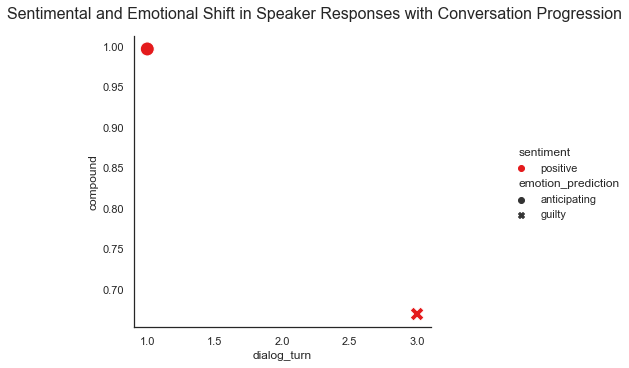

In [132]:
test_examples(23)

Conversation length:  4
Speaker listener ratio:  2  -->  moderate engagement
Sentiment shift:  0.61  with grateful bonus:  0.4  -->  moderate satisfaction
Classification summary:  moderate engagement, moderate satisfaction


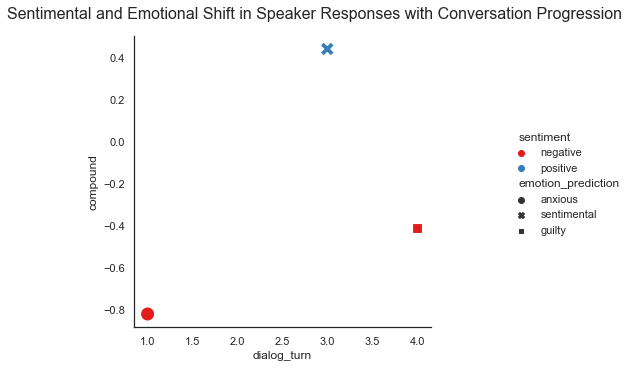

In [133]:
test_examples(24)

### High engagement, positive satisfaction

### High engagement, negative satisfaction

### Moderate engagement, moderate satisfaction

### Low engagement, neutral satisfaction

## Emotion prediction is not accurate at all...

In [122]:
#conversation_bad_emotion_prediction_example = df[df["conversation_id"] == 1754]
#conversation_bad_emotion_prediction_example

When we check the emotion predictions, we see that most of them are very inaccurate. The sentiment tags are more accurate, but sometimes they fail too.

In [123]:
#df[df["emotion_prediction"]=="questioning"]

The questioning tags are not accurate either. Only one of the statements that are tagged with the questioning tag are actually questioning.

In [124]:
#df[df["emotion_prediction"]=="suggesting"]

There are no turns tagged as suggesting.

## TODO: Improve these scoring functions

Satisfaction: 
- Take off points if speaker got offended from listener's response
- Find a lexicon of gratitude tokens

Engagement:
- Number of tokens speaker used to respond back (excluding the first turn), i.e. when the speaker responds back, is it a shorter/longer response elaborating the situation
- Check if the turns are interleaved (i.e. if there is interaction)
- Change ratio to difference

Examples:
- A few examples showing low/moderate/high engagement/satisfaction
